<a href="https://colab.research.google.com/github/srijayjk/Deep-Learning/blob/master/Simple_regression_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning programming I-A: Regression
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 24.04.2020

## Introduction
This programming exercise is the first of a series of exercises, which are intended as a supplement to the theoretical part of the Deep Learning course offered by the ISS. The goal is to introduce you to basic tasks and applications of methods you have encountered in the lecture. After completing the exercise you should be familiar with the basic ideas and one, possibly simple, way of solving the respective task. It is worth mentioning that most of the tasks can be solved in many different, not necessarily deep learning based, ways and the solution presented here is just one of them.

## Regression

In this exercise we consider the problem of regression, where we are interested in modeling a functional dependence between different variables with, possibly noisy, observations of input-output pairs. Mathematically such a dependence can be formulated as

$\mathbf{y}=f(\mathbf{x})+\boldsymbol{\epsilon}$,

where $\mathbf{y}\in\mathbb{R}^{M}$ and $\mathbf{x}\in\mathbb{R}^{N}$ are the input and output observations, $f:\mathbb{R}^{N}\rightarrow\mathbb{R}^{M}$ is the function mapping inputs to outputs and $\boldsymbol{\epsilon}\in\mathbb{R}^{M}$ is a random vector, which models noise in our observations. Note that this assumes additive noise that only acts on the output and not on the input variable, which might not be true in all practical applications but is a reasonable approximation. For regression we are now interested in estimating the functional relationship $f$ between the inputs and outputs. This can be done in many different ways, not just with neural networks, but for this exercise we focus on approximating this relationship with a neural network $g_{\boldsymbol{\theta}}:\mathbb{R}^{N}\rightarrow\mathbb{R}^{M}$ with parameter vector $\boldsymbol{\theta}$. The task is now to choose the parameters of the neural network in a way that results in a "good" approximation of $f$ with $g_{\boldsymbol{\theta}}$.

In order to quantify how "good" our neural network can approximate $f$, we adopt a probabilistic view. For this we make the assumption that the noise $\boldsymbol{\epsilon}$ is a random vector drawn from a known dustribution, which enables us to derive a suitable cost function for training our neural network and also for quantifying a "good" approximation.

### Mathematical formulation
If we assume that the noise $\boldsymbol{\epsilon}$ is drawn from a gaussian distribution, e.g. $\boldsymbol{\epsilon}\sim\mathcal{N}(\mathbf{0},\sigma^{2}\mathbf{I})$, we can use

$\mathbf{y}=g_{\boldsymbol{\theta}}(\mathbf{x})+\boldsymbol{\epsilon}\Rightarrow \mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})=\boldsymbol{\epsilon}$

to derive a log likelihood. Since the probability density function (pdf) of a multivariate normal distribution is given by

$p(\mathbf{x})=\dfrac{1}{\sqrt{(2\pi)^{D}\vert\mathbf{C}\vert}}\mathrm{e}^{-\dfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu})\mathbf{C}^{-1}(\mathbf{x}-\boldsymbol{\mu})^{T}}$,

we get

$\ln{p(\boldsymbol{\epsilon})}=\ln{\dfrac{1}{\sqrt{(2\pi)^{M}\sigma^{2}}}\mathrm{e}^{-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\epsilon}\Vert_{2}^{2}}}=-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\epsilon}\Vert_{2}^{2}-\dfrac{1}{2}\ln{(2\pi)^{M}\sigma^{2}}$.

Replacing $\boldsymbol{\epsilon}$ by $\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})$ yields the log likelihood for one particular input-output pair:

$\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})=\ln {p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})}=-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}-\dfrac{1}{2}\ln{(2\pi)^{M}\sigma^{2}}$

This log likelihood measures how likely the input-output pair is and we can use it to train our neural network. For this we maximize the expected log likelihood over all input-output pairs under the assumption that the noise is idependent and identically distributed (i.i.d.) over all input-output pairs. This corresponds to finding the parameters $\boldsymbol{\theta}^{\star}$ of our neural network, which maximize the the expected probability for observing the corresponding input-output pairs. Mathematically the optimal parameters for our neural network are given by

$\boldsymbol{\theta}^{\star}=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})\right]=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[-\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}\right]\approx\arg\min_{\boldsymbol{\theta}}\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where all terms, which are independent of $\boldsymbol{\theta}$, are ignored and the expectation operator is approximated by the mean over all $N_{D}$ input-output pairs. In other words we are maximizing the log likelihood by minimizing the mean squared error loss over all input-output pairs in our dataset, hence this approach is called Maximum Likelihood (ML) estimation. For solving this optimization problem and obtaining the optimal network parameters, stochastic gradient descent (SGD) or one of it's many variants is typically used.

It is worth noting, that choosing different distributions for the noise $\boldsymbol{\epsilon}$ leads to different log likelihoods and therefore different cost functions for training the neural network. Another commonly used distribution for modelling the noise in regression tasks is the laplace distribution. Deriving the log likelihood and the corresponding costfunction leads to the mean absolute error, which is given by the $l_{1}$-norm of the difference between observations predictions of the neural network. This cost function is considered more robust against outliers since these have less influence on the averall loss compared to the mean squared error.

###  Implementation

In the following we consider a simple regression task, implement a neural network and train it based on the mathematical fomrulation above. For this we first need to create a set of input-output pairs, which then needs to be partitioned into a training, validation and test set. We also define some constants to be used for partitioning the data and the hyperparameters for our neural network.

But before we can start, we need to import the necessary packages tensorflow, numpy and matplotlib.

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Next we define our constants and set the random seeds of tensorflow and numpy in order to get reproducable results.

In [0]:
N_train_samples = 600
N_validation_samples = 100
N_test_samples = 100
N_samples = N_train_samples + N_validation_samples + N_test_samples
noise_sig = 0.1
N_epochs = 150
batch_size = 8
learning_rate = 0.01

tf.random.set_seed(0)
np.random.seed(0)

We create $600$ training samples, $100$ validation samples to optimize our hyperparameters and $100$ test samples, which are used to check if our model can generalize to unseen data. Furthermore we set the level of noise added to the observations. For training the model we plan to train it for $150$ epochs with a batch size of $8$ and a learning rate of $0.01$. Next we create the actual input-output pairs $\mathbf{x},\mathbf{y}$ for which we want to learn the regression model and plot them. In this simple example we choose scalar inputs as well as output but in general $\mathbf{x}$ and $\mathbf{y}$ can be vectors.

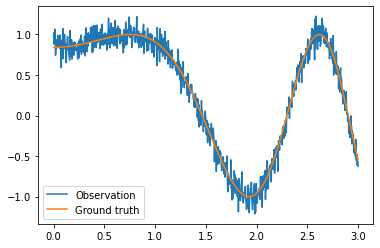

In [59]:
x = np.linspace(0.0, 3.0, N_samples, dtype=np.float32)
y = np.expand_dims(np.sin(1.0+x*x) + noise_sig*np.random.randn(N_samples).astype(np.float32), axis=-1)
y_true = np.sin(1.0+x*x)

plt.plot(x, y)
plt.plot(x, y_true)
plt.legend(["Observation", "Ground truth"])
plt.show()

With the input-output pairs created, your first task is now to partition the data in the training, validation and test sets. Keep in mind that we have created the data in a structured way, i.e. the input-output pairs are ordered. This means you need to shuffle the data before partitioning it.

In [0]:
""" Shuffle and partition the data set accordingly. you can use the predefined constants "N_train_samples", "N_validation_samples" and "N_test_samples". Use the variable names that are already in the below code 
to store the final shuffled and partitioned data. Hint: Shuffle the data and the labels in such a way that the pairing between an image and it's label is preserved."""
# Shuffle the data
"""shu = np.arange(0, N_samples)
print(np.shape(shu))
shu = np.random.choice(shu, N_samples)

x = x[shu]
y = y[shu]"""


# Partition the data
x_train = x[:N_train_samples]
y_train = y[:N_train_samples]

x_validation = x[N_train_samples:N_train_samples+100]
y_validation = y[N_train_samples:N_train_samples+100]

x_test = x[N_train_samples+100:N_train_samples+200]
y_test = y[N_train_samples+100:N_train_samples+200]

In order to feed the data to our model, we will use the Dataset class provided by Tensorflow. This class is simple to use and provides all the functionality we need for shuffling, batching and feeding the data to our model. It is also tightly integrated into the Tensorflow framework, which makes it very performant. Performance is not an aspect we need to worry about in this exercise, but it is important in more demanding applications.

In this exercise we instantiate a separate Dataset object for the training, validation and test data sets, where we shuffle and repeat just the training data set. Shuffling the validation and test data sets is not necessary, since we only evaluate the loss on those data sets and do not perform SGD on it. Please fill in the missing part of the code.

In [0]:
""" Create three tensorflow Dataset objects that can be used to feed the training test and validation data to a neural network. Hint: For the training data set use shuffling, batching with the size according to
the predefined constant "batch_size" and repeat the data set indefinetly. For the validation and test data sets no shuffling or batching is needed."""
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.shuffle(buffer_size=N_train_samples)
train_ds = train_ds.batch(batch_size)

validation_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In this exercise we will create a a simple neural network with two hidden layers containing $10$ neurons. For creating a model and keeping track of its weights a class called MyModel is used. When initializing an instance of this class the necessary variables are created and stored in a list called "trainable_variables". This makes it easy to get all trainable variables of the model. We also override the \__call__ method of this class in order to implement the forward pass of the neural network. This method should accept the inputs to the neural network and should return the result of the forward pass as an output. Please fill in the missing part of the code and select suitable activation functions for the different layers.

In [0]:
""" Implement a neural network with two hidden dense layers containing 10 neurons each. As an activation function use the tangens hyperbolicus (tf.nn.tanh()). Since we are not using Keras, we need to create and 
manage all the variables that we need ourselves. The varaibles are created in the constructor of our model class. Since we want to be able to just call the class with some inputs in order to make a prediction, 
we implement a __call__ method which computes the forward pass and returns the output of the network."""

class MyModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.uniform([1, 10]))
        self.b0 = tf.Variable(tf.zeros([1]))
        self.W1 = tf.Variable(tf.random.uniform([10, 10]))
        self.b1 = tf.Variable(tf.zeros([1]))
        self.W2 = tf.Variable(tf.random.uniform([10, 1]))
        self.b2 = tf.Variable(tf.zeros([1]))
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W0), self.b0))
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W1), self.b1))
        output = tf.nn.tanh(tf.add(tf.matmul(output, self.W2), self.b2))
        return output

Now after the model class is defined we can instantiate a MyModel object by running

In [0]:
mdl = MyModel()

We can now use the model to make predictions by calling it. In the following we predict on the inputs an plot the result.

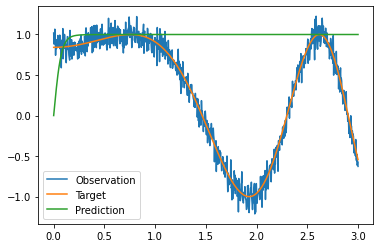

In [64]:
""" We want to plot a prediction on the complete data set with a model before training. For this make a prediction on the variable "x". """

y_pred = mdl(x) # Compute a prediction on the variable "x"
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Since we have initialized the variables of the neural network randomly, it's prediction is also random. In order to fit the model we need to minimize the expected mean squared error over all input-ouput pairs in our training data set. For this we need to create a function, that performs a training step when provided with the model, an optimizer and a batch of input-ouput pairs.

In [0]:
""" For training we need to implement a function that executes one training step. Fill in the missing code pieces for this function."""

def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x) # Compute a prediction with "model" on the input "x"
        loss_val = tf.math.reduce_mean(tf.math.square(y - y_pred)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y"
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

This function uses the GradientTape to record the operations for which gradients have to be calculated. In our case this is the forward pass through our model and the computation of the loss function. After these operations are recoded we can get their gradients and apply these through the use of an optimizer. Finally we return the loss value in order to print it.

With the training step function defined we now need to choose a suitable optimizer. Tensorflow offers a wide variety of optimizers but in this exercise we will use the RMSprop optimizer.

In [0]:
opt = tf.optimizers.RMSprop(learning_rate)

We now have everything we need to start training the model. For this we repeatedly sample a batch of input-output pairs from our training data set and use the train_step function to minimize the loss function over this batch. We repeat this until we have iterated over the complete training data set once. After this we compute the loss on the validation data set, print it and repeat with another epoch until we have reached $N\_epochs$ epochs.

In [0]:
""" We can now use the train_step function to perform the training. Fill in the missing code parts."""

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_ds:
    train_loss += train_step(mdl, opt, x_t, y_t)# Perform a training step with the model "mdl" and the optimizer "opt" on the inputs "x_t" and the corresponding targets "y_t"
    train_iters += 1
    if(epoch<N_epochs): # An epoch is completed
        for x_v, y_v in validation_ds:
            y_pred = mdl(x_v) # Compute a prediction with "mdl" on the input "x_v"
            validation_loss = tf.reduce_mean(tf.square(y_pred - y_validation)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_v"
        #print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

After completion of the training process we use the test data set to test the models generalization to unseen data.

In [68]:
for x_t, y_t in test_ds:
    y_pred = mdl(x_t)# Compute a prediction with "mdl" on the input "x_t"
    test_loss = tf.reduce_mean(tf.square(y_pred - y_t)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_t"
print("Test loss: {:.5}".format(test_loss))

Test loss: 0.19081


After we have verified that our model achieves a similar loss on the test as on the validation and training data set, we can conclude that our model is not overfitting or underfitting and generalizes to unseen data. We can now predict on the inputs again and plot the results.

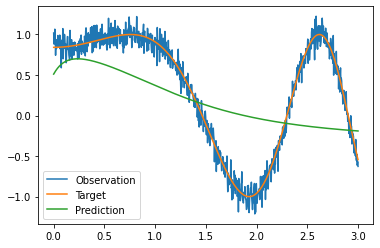

In [69]:
""" Now we want to plot the prediction after training. Predict on the variable "x" again. """

y_pred = mdl(x)# Compute a prediction on the variable "x"
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Now our model has learned to approximate the function mapping from the input to the output. The capability of neural networks to learn from input-ouput pairs alone and approximate an arbitrary function, see universal approximation theorem, can be very useful if the mapping between the input and output is too complex to be captured with model based approaches. But learning from input-ouput pairs alone implies that the model will only be able to make accurate predictions over input ranges it has seen during training. In order to demonstrate this we will predict on an interval that exeeds the $\left[0,3\right]$ interval the model was trained on, i.e. we will predict on the interval $\left[-2,5\right]$.

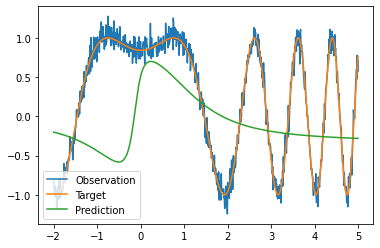

In [70]:
x_generalize = np.linspace(-2.0, 5.0, N_samples, dtype=np.float32)
y_generalize = np.sin(1.0+x_generalize*x_generalize) + noise_sig*np.random.randn(N_samples).astype(np.float32)
y_truey_generalize = np.sin(1.0+x_generalize*x_generalize)
y_pred = mdl(x_generalize)
plt.plot(x_generalize, y_generalize)
plt.plot(x_generalize, y_truey_generalize)
plt.plot(x_generalize, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

As expected, the model is able to make farely accurate predictions on the interval it was trained on but makes unreliable predictions outside this interval.

### Regularization
In this section we will explore the concept of regularization. As there is no theorem that can be used to determine the required size and structure of a neural network given a certain task, one has to find a suitable neural architecture by trial and error. This can result in choosing a architecture with a capacity that is higher than required for solving the given task and hence overfitting might occur. A common way to prevent large neural networks networks from overfitting is to employ some sort of regularization, e.g. weight norm penalty, dropout, early stopping and data augmentation. In this section we will focus on weight norm penalty as a regularization and derive a probabilistic interpretation for some of those.

We start by restating the conditional probability of the output $\mathbf{y}$ given the input $\mathbf{x}$ and the networks parameters $\boldsymbol{\theta}$

$p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})=\dfrac{1}{\sqrt{(2\pi)^{M}\sigma^{2}}}\mathrm{e}^{-\dfrac{1}{2\sigma^{2}}\Vert\boldsymbol{\mathbf{y}-g_{\boldsymbol{\theta}}(\mathbf{x})}\Vert_{2}^{2}}$,

which we used to derive the log likelihood. If we have some prior knowledge about the parameters of the neural network, which is given by a pdf $p(\boldsymbol{\theta})$ over the weights, we can use Bayes theorem to derive a posterior distribution

$p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})=\dfrac{p(\boldsymbol{\theta},\mathbf{y}\vert\mathbf{x})}{p(\mathbf{y})}=\dfrac{p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y})}$

where $p(\boldsymbol{\theta})$ is the  prior over the networks parameters. Similar to the derivation at the beginning of the exercise, we can use this posterior distribution to derive a cost function for training the neural network. In this case, however, we are not maximizing the log likelihood but the posterior distribution over the weights, hence this approach is called Maximum A Posteori (MAP) estimation of the parameters. Mathematically we can formulate this as

$\boldsymbol{\theta}^{\star}=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})\right]=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[\ln{p(\boldsymbol{\theta}\vert\mathbf{x},\mathbf{y})}\right]=\arg\max_{\boldsymbol{\theta}}\ln{p(\boldsymbol{\theta})}+\mathbb{E}\left[\ln{p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})}\right]$,

where we used the fact that applying a strictly increasing function, e.g. $\ln{}$, does not change the position of the maximum of a cost function, ignored $p(\mathbf{y})$, since it is independent of the network parameters and dropped the expectation operator for $\ln{p(\boldsymbol{\theta})}$, since it is not depending on the random variable $\mathbf{x}$. Comparing the MAP estimate of the parameters with the ML estimate we derived above, shows that the only difference is the addition of $\ln{p(\boldsymbol{\theta})}$. This term is the regularization, i.e. the weight norm penalty. Depending on the distribution over $\boldsymbol{\theta}$ it can have different forms. If we choose a standard normal distribution, i.e. $\boldsymbol{\theta\sim\mathcal{N}(\mathbf{0},\mathbf{I})}$,  we get

$\boldsymbol{\theta}^{\star}=\arg\min_{\boldsymbol{\theta}}\lambda\Vert\boldsymbol{\theta}\Vert_{2}^{2}+\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where we have made the same simplifications as for the ML estimation and also introduced the parameter $\lambda=\sigma^{2}$, which is used to control the strength of the regularization. This form of regularization is commonly known as $l_{2}$-norm or weight decay regularization. Choosing a prior where the weights follow an i.i.d laplacian distribution, i.e. $p(\boldsymbol{\theta})=\prod_{j}\dfrac{1}{2}\mathrm{e}^{\vert\theta_{j}\vert}$, leads to

$\boldsymbol{\theta}^{\star}=\arg\min_{\boldsymbol{\theta}}\lambda\Vert\boldsymbol{\theta}\Vert_{1}+\dfrac{1}{N_{D}}\sum_{i=1}^{N_{D}}\Vert\boldsymbol{\mathbf{y}_{i}-g_{\boldsymbol{\theta}}(\mathbf{x}_{i})}\Vert_{2}^{2}$,

where the strength of the regularization is again controlled by $\lambda=\sigma^{2}$. This type of regularization is known as  $l_{1}$-norm and it has the property to induce sparsity in the parameters of the network.

With this theoretical background on regularization we can now implement it and observe it's effects on the regression problem covered in this exercise. For this we will define a model with a high capacity and train it for a extended time to provoke overfitting. For this, we will increase the number of hidden neurons in both hidden layers to $100$ and $50$.

In [0]:
""" Implement a bigger model with again two hidden layers contatining 100 and 50 neurons. As an activation use the tangens hyperbolicus function where it is appropiate. """

class MyBigModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.uniform([1, 100]))
        self.b0 = tf.Variable(tf.zeros([1]))
        self.W1 = tf.Variable(tf.random.uniform([100, 50]))
        self.b1 = tf.Variable(tf.zeros([1]))
        self.W2 = tf.Variable(tf.random.uniform([50, 1]))
        self.b2 = tf.Variable(tf.zeros([1]))
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.matmul(output, self.W0) + self.b0)
        output = tf.nn.tanh(tf.matmul(output, self.W1) + self.b1)
        output = tf.nn.tanh(tf.matmul(output, self.W2) + self.b2)
        return output

After creating one instance of this class we can again train it on our data set. We will also create a new optimizer for training this bigger model, since some optimizers adapt the learning rates for individual parameters during a training process and we do not want to train our bigger model with learning rates adopted from an earlier training run.

In [0]:
big_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

Now we are ready to train this bigger model using the same training step and training loop. In order to provoke overfitting we also reduce the number of samples in the training data set a lot, increase the batch size and train for a more epochs.

In [0]:
""" Implement the training for the bigger model similar to the training of the small model before. """

N_train_samples_overfit = 30
N_epochs = 1000
batch_size = 30

sel_idx = np.arange(0, N_train_samples)
sel_idx = np.random.choice(sel_idx, N_train_samples_overfit)
x_train_overfit = x_train[sel_idx]
y_train_overfit = y_train[sel_idx]

print(x_train_overfit)
x_train_overfit = tf.constant(x_train_overfit, shape = [1, tf.size(x_train_overfit)])
y_train_overfit = tf.constant(y_train_overfit, shape = [1, tf.size(y_train_overfit)])
print(np.shape(y_train_overfit))


train_overfit_ds = tf.data.Dataset.from_tensor_slices((x_train_overfit, y_train_overfit)).shuffle(N_train_samples_overfit).batch(batch_size).repeat()

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    train_loss += train_step(big_mdl, big_opt, x_t, y_t) # Perform a training step with the model "big_mdl" and the optimizer "big_opt" on the inputs "x_t" and the corresponding targets "y_t"
    train_iters += 1
    if(epoch<N_epochs): # An epoch is completed
        for x_v, y_v in validation_ds:
            y_pred = big_mdl(x_v)# Compute a prediction with "big_mdl" on the input "x_v"
            validation_loss = tf.reduce_mean(tf.square(y_pred - y_v)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_v"
        #print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

[1.0062578  2.1627033  0.2703379  1.4906132  0.49186483 0.86357945
 1.7046307  1.5168961  0.00750939 0.65707135 1.9186484  2.140175
 0.41301626 2.2302878  0.95369214 2.2227786  1.175219   1.0851064
 1.8397998  0.25907385 0.82978725 0.2966208  0.33416772 1.8510638
 1.0513141  1.3366709  1.6708386  0.28911138 1.9674593  0.42428035]
(1, 30)


Predicting with this model shows overfitting. For recognizing overfitting a comparison of the validation and training loss is very useful. If the training loss decreases during training while the validation loss consistently increases, the model you are training is probably overfitting. Plotting the models prediction and the target also shows that there is a significant discrepancy between the target and the prediction of the model.

In [0]:
y_pred =big_mdl(x) # Predict on x with "big_mdl"
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Target", "Prediction", "Training samples"])
plt.show()

In order to implement a regularization we need to modify the loss function. Since the loss function in this exercise is computed during the training step, we define a new training step with a regularization.

In [0]:
""" In order to avoid overfitting we implement a training step that also includes a regularization on the weights of our big model. For this we use the Frobenius/squared l2-norm of each weight matrix/vector. 
Hint: Use the tf.reduce_sum() function on a list of individual regularization terms for each matrix/vector of the network."""

def regularized_train_step(model, optimizer, x, y, lmbd):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x) # Compute a prediction with "model" on the input "x"
        loss_val = tf.math.reduce_mean(tf.math.square(y - y_pred)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y"
        regul_val = (np.sum(np.square(model.trainable_variables[0]))+
                            np.sum(np.square(model.trainable_variables[2]))+
                            np.sum(np.square(model.trainable_variables[4]))) # Compute the regularization based on the list "model.trainable_variables"
        total_loss = loss_val + (lmbd * regul_val)# Add the loss with a the regularization term weighted by "lmbd"
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

We can now set the strength of the regularization and retrain the big model with a regularization. We create another instance of the big model in order to compare the big model with and without regularization.

In [0]:
""" Implement the training for the bigger model with the regularized_train_step function. Note: We are plotting the MSE loss without the regularization in order to compare it with the unregularized model. """

lmbd = 0.005

big_reg_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    train_loss += regularized_train_step(big_mdl, big_opt, x_t, y_t, lmbd) # Perform a regularized training step with the model "big_mdl" and the optimizer "big_opt" on the inputs "x_t" and the corresponding targets "y_t" with the regularization parameter being "lmbd"
    train_iters += 1
    if(epoch<N_epochs): # An epoch is completed
        for x_v, y_v in validation_ds:
            y_pred = big_mdl(x_v) # Compute a prediction with "big_mdl" on the input "x_v"
            validation_loss = tf.math.reduce_mean(tf.square(y_v - y_pred)) # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_v"
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        train_reg = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

During the training of the regularized model we can already notice, that, although there is still a difference between training and validation loss, the validation loss decreases as the training loss dreases. The effect of the regularization becomes even more evident if we plot the predictions of the regularized model and the overfitting model.

In [0]:
""" We now want to plot the prediction of the regularized and unregularized big model. """

y_pred = big_reg_mdl(x)# Predict with "big_reg_mdl" on "x"
y_pred_overfit = big_mdl(x) # Predict with "reg_mdl" on "x"
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.plot(x, y_pred_overfit.numpy())
plt.legend(["Target", "Regularization", "No regularization", "Training samples"])
plt.show()

The model with regularization seems to follow the overall trend of the data, while the model without any regularization very precisely fits the training samples. This is espacilly evident in the interval $\left[0,0.5\right]$, where the prediction of the unregularized model shows an oscillating behavior. Such oscillations are however not present in the ground truth and therefore undesirable. The regularized model on the other hand is not as flexible as the unregularized model and therefore does not fit the target function well in the interval $\left[2.25, 3.0\right]$.

## Conclusion
In this exercise we revisited the mathematical background for a simple regression task and covered it's practical implementation in Tensorflow 2. We also explored the phenomenon of overfitting and derived different regularizations from a probabilistic perspective. This exercise covers a very simple task with a very basic neural architecture and is intended as a primer for the second part of the regression exercise, which is dealing with a bigger and more realistic problem. In this second part we will consider the problem of estimating the age of a person from a potrait picture.